# California Housing Market Analysis

Predicting median house value of an area based on attributes of that geographic area.

In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml/master/'
HOUSING_PATH = 'datasets/housing'
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + '/housing.tgz'

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
import pandas as pd
import numpy as np

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [3]:
fetch_housing_data()
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


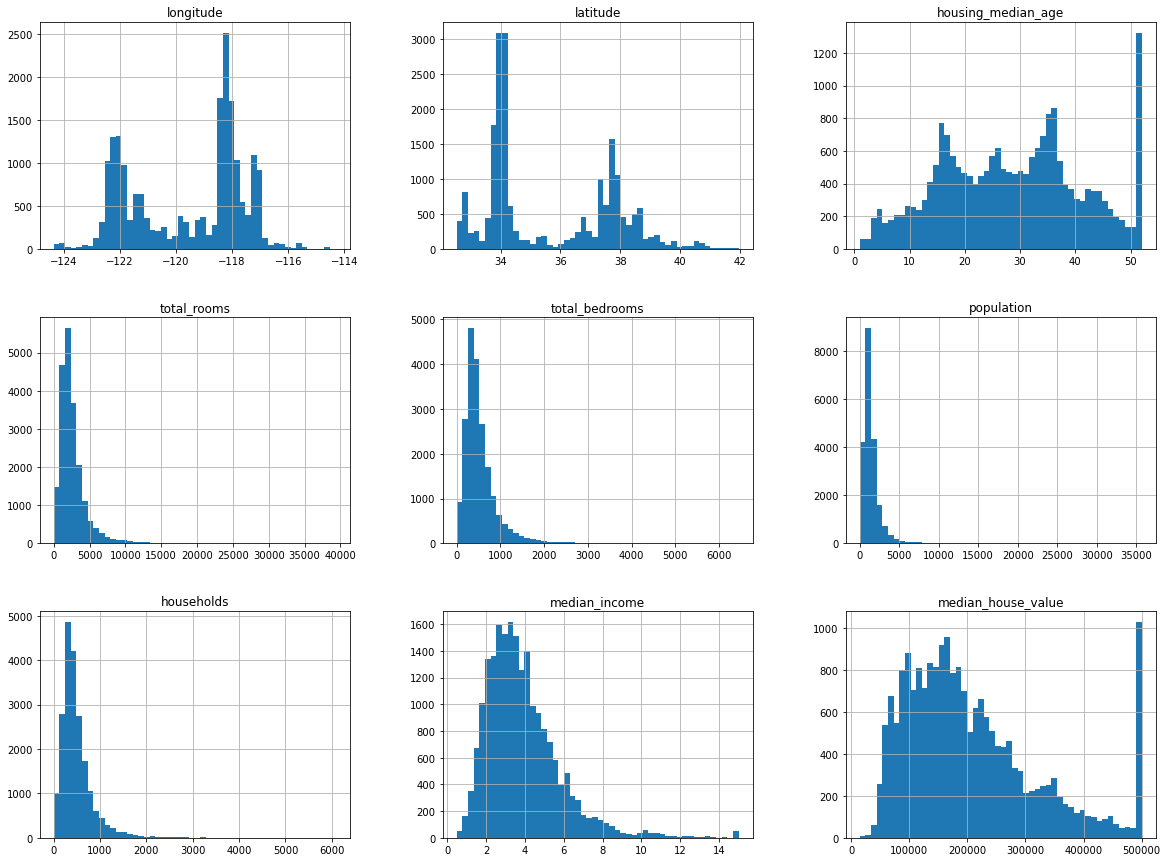

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize = (20, 15))
plt.show()

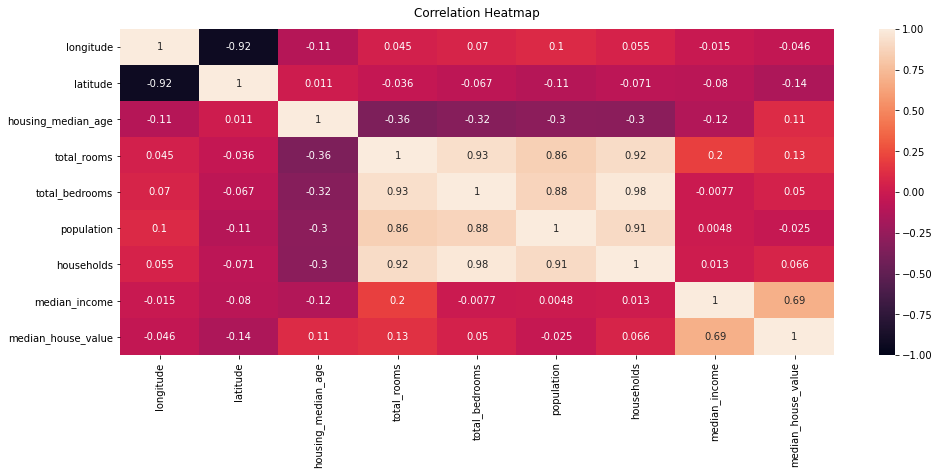

In [5]:
import seaborn as sns
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(housing.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

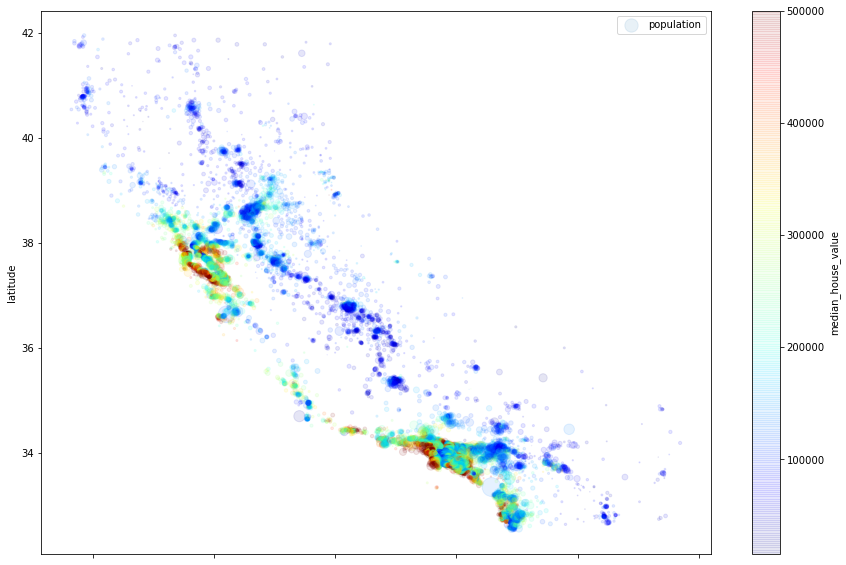

In [6]:
housing.plot(
    kind='scatter',
    x='longitude',
    y='latitude', 
    figsize=(15,10), 
    alpha=0.1,
    s=housing['population']/100,
    label='population',
    c='median_house_value',
    cmap=plt.get_cmap('jet'),
    colorbar=True
)
plt.show()

In [7]:
housing_features = housing.drop("median_house_value", axis=1) # drop labels features
housing_labels = housing["median_house_value"].copy()

In [8]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

housing_num = housing_features.drop(columns = ['ocean_proximity'])
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

#the numeric attributes transformation pipeline
num_pipeline = Pipeline([        
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scalar', StandardScaler())  
])

cat_pipeline = Pipeline([        
    ("text", OrdinalEncoder())
])


#setting the order of the two pipelines
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing_features)
housing_prepared = pd.DataFrame(housing_prepared, columns = housing_features.columns)
housing_prepared.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-1.327835,1.052548,0.982143,-0.804819,-0.972476,-0.974429,-0.977033,2.344766,3.0
1,-1.322844,1.043185,-0.607019,2.045890,1.357143,0.861439,1.669961,2.332238,3.0
2,-1.332827,1.038503,1.856182,-0.535746,-0.827024,-0.820777,-0.843637,1.782699,3.0
3,-1.337818,1.038503,1.856182,-0.624215,-0.719723,-0.766028,-0.733781,0.932968,3.0
4,-1.337818,1.038503,1.856182,-0.462404,-0.612423,-0.759847,-0.629157,-0.012881,3.0


In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(housing_prepared, housing_labels, test_size = .2, random_state = 42)

In [10]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [11]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

housing_predictions = lin_reg.predict(x_train)
lin_mse = mean_squared_error(y_train, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print('Training set RMSE: ' + str(lin_rmse))


lin_scores = cross_val_score(lin_reg, x_train, y_train,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Training set RMSE: 69361.0714290645
Scores: [66187.62479242 72779.35713344 68950.17710356 67634.12212475
 70452.68132171 66516.76635312 66535.02116758 71001.14354709
 74319.03994135 70669.19262425]
Mean: 69504.5126109282
Standard deviation: 2663.673929328216


In [12]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(x_train, y_train)

housing_predictions = tree_reg.predict(x_train)
tree_mse = mean_squared_error(y_train, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print('Training set RMSE: ' + str(tree_rmse))

scores = cross_val_score(tree_reg, x_train, y_train,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Training set RMSE: 0.0
Scores: [69350.74061007 71058.12719937 69883.95305108 73085.05773
 71202.64387997 67369.11369819 68416.22406007 68807.8414225
 73863.13697351 70914.36009214]
Mean: 70395.11987169074
Standard deviation: 1938.257126345832


In [13]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(x_train, y_train)

housing_predictions = forest_reg.predict(x_train)
forest_mse = mean_squared_error(y_train, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print('Training set RMSE: ' + str(forest_rmse))

from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, x_train, y_train,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Training set RMSE: 21848.62351796237
Scores: [51552.42659533 53715.17170575 51089.89000238 54138.17457625
 53298.79208754 50157.27413986 48122.10366663 53502.17895987
 54076.12836301 51890.71469216]
Mean: 52154.28547887709
Standard deviation: 1870.9238335519067


In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30, 40], 'max_features': [2,4,6,8]},
    {'bootstrap': [False], 'n_estimators':[3, 10, 20, 30], 'max_features':[2,4, 6, 8]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv = 5, scoring = 'neg_mean_squared_error')

grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30, 40]},
                         {'bootstrap': [False], 'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 20, 30]}],
             scoring='neg_mean_squared_error')

In [15]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, max_features=4, n_estimators=30)

In [16]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

62053.76928692236 {'max_features': 2, 'n_estimators': 3}
53532.123869513816 {'max_features': 2, 'n_estimators': 10}
51168.644386709704 {'max_features': 2, 'n_estimators': 30}
50799.897244286345 {'max_features': 2, 'n_estimators': 40}
59258.80106815771 {'max_features': 4, 'n_estimators': 3}
51507.87051751233 {'max_features': 4, 'n_estimators': 10}
49508.87379163169 {'max_features': 4, 'n_estimators': 30}
49282.17969423601 {'max_features': 4, 'n_estimators': 40}
57761.328646313756 {'max_features': 6, 'n_estimators': 3}
51554.97630638784 {'max_features': 6, 'n_estimators': 10}
49641.86360826232 {'max_features': 6, 'n_estimators': 30}
49300.556348646096 {'max_features': 6, 'n_estimators': 40}
57118.21243126723 {'max_features': 8, 'n_estimators': 3}
52168.410344085874 {'max_features': 8, 'n_estimators': 10}
50049.452998905224 {'max_features': 8, 'n_estimators': 30}
49864.74109184563 {'max_features': 8, 'n_estimators': 40}
60330.16038138543 {'bootstrap': False, 'max_features': 2, 'n_estimato

In [17]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

attributes = list(housing_features)
sorted(zip(feature_importances, attributes), reverse=True)

[(0.43019063885657705, 'median_income'),
 (0.15162584371078522, 'longitude'),
 (0.13420992028777215, 'latitude'),
 (0.1039142750735782, 'ocean_proximity'),
 (0.04938667695080682, 'housing_median_age'),
 (0.04130588010576264, 'population'),
 (0.0347161906343458, 'total_rooms'),
 (0.028643187737750427, 'total_bedrooms'),
 (0.02600738664262155, 'households')]

In [18]:
model_rf = grid_search.best_estimator_

model_pred = model_rf.predict(x_test)
final_mse = mean_squared_error(y_test, model_pred)
final_rmse = np.sqrt(final_mse)
final_rmse

49172.83902363007